# EDA Notebook

## Data Understanding

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import data_preparation_functions as dp
import figure_functions as fg
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import jarque_bera
import math

plt.style.use('bmh')
%matplotlib inline

In [2]:
# Load Kings county database and preview first few entries
kc_df = pd.read_csv('data/kc_house_data.csv')
kc_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# Taking a look at all the columns, data types, and missing entries
kc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The data contains 21 total columns, 12 of type int or float, and 6 of type object. It contains:

- `id` column which have a unique id value for each house
- `date` column with the sale date (Years 2014 - 2015)
- `price` column with the price of sale and our target variable
    - <p>mean: \$540296</p>
    - <p>std: \$367368</p>
- `bedrooms`, `bathrooms` and `floors` columns with counts of each in their respective house
- four area variables, (`sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`), defining the square footage of living space, lot space, area of house apart from the basement, and area of the basement.
- two area variables, (`sqft_living15`, `sqft_lot15`), describing the living and lot area of the 15 nearest neighbors
- `waterfront` variable of whether the house is on a waterfront (Yes/No)
- `view` describing quality of view from house
    - (None, Fair, Average, Good, Excellent)
- `condition` for the overall maintanence condition of the house
    - (Poor, Fair, Average, Good, Very Good)
- `grade` describing overall construction and design grade of the house 
    - (Poor, Low, Fair, Low Average, Average, Good, Better, Very Good, Excellent, Luxury, Mansion)
- `yr_built` for when the house was built
- `yr_renovated` for when house was renovated last (if applicable)
- three location columns detailing `zipcode`, latitude (`lat`) and longitude (`long`) of the house.
    - Data consists of an area covering 70 zipcodes


In [4]:
# Checking the years spanned by the data set
sales_year = kc_df.date.map(lambda x: int(x[-4:]))

print('The data spans the years {} to {}'.format(min(sales_year), max(sales_year)))

# finds mean and standard deviation of price
print('Sales price mean: ${}, stdev: ${}'.format(int(kc_df.price.mean()),int(kc_df.price.std())))

The data spans the years 2014 to 2015
Sales price mean: $540296, stdev: $367368


In [5]:
# Checking view values
kc_df.view.value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [6]:
# Checking condition values
kc_df.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [7]:
# Checking grade values
kc_df.grade.value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [8]:
# Checking how many unique zipcodes are included in the dataset
num_of_zip = len(kc_df.zipcode.unique())
print('There are {} unique zipcodes in this data set'.format(num_of_zip))

There are 70 unique zipcodes in this data set


## Data Preparation


At first glance, the columns for `id`, latitude (`lat`), and longitude (`long`) can be removed. The `id` column is good for reference, but not good for a linear regression model. The latitude and longitude appear to be difficult variables to deal with since they describe an exact location. In a linear regression model their seperate coefficients would only be good for how far in a cordinal direction they are. Having zones like a zipcode would be preferable as that defines a region, though having 70 unique zipcodes in our data set would create a lot of columns if they were treated categorically and one hot encoded. On the other hand treating them as continuous data doesn't make sense as they are not in an order with any statistical significance. Therefore the `zipcode` column will also be ommitted from our calculations. Another column that can be removed is the `date`. If our data set spanned a longer time this column may be used to adjust for inflation, or observe outside conditions that caused housing prices to drastically change like the 2006 housing bubble. Since our data only spans the years of 2014 and 2015 this isn't necessary.

We also have to consider which columns can actually pertain to our problem. We are looking for the best variables to improve to increase the sales price. Variables like `waterfront`, `sqft_lot`, `view`, `yr_built`, `yr_renovated`, `sqft_basement`, `sqft_living15` and `sqft_lot15` are variables that depend on location and are impossible or very hard to change. Considering this these variables will also be ommitted from our calculations.

Another thing to consider is correlation between features. Looking at the feature descriptions `sqft_living` and `sqft_above` may be very similar. Let's check their correlations.

In [9]:
kc_df[['sqft_living', 'sqft_above']].corr().iloc[0, 1]

0.8764477590354868

There's some clear correlation between them, and seeing as most living space is above the basement this most likely isn't spurious correlation. Therefore one of the variables should be dropped from the analysis. 

In [10]:
# Dropping unnecessary columns from original dataset
unn_columns = ['id', 'date', 'lat', 'long', 'zipcode', 'waterfront',
               'view', 'yr_built', 'yr_renovated', 'sqft_living15',
              'sqft_lot15', 'sqft_lot', 'sqft_basement', 'sqft_above']

kc_df_iprep = kc_df.drop(columns=unn_columns, axis=1).copy()
kc_df_iprep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   floors       21597 non-null  float64
 5   condition    21597 non-null  object 
 6   grade        21597 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 1.2+ MB


We now need to handle the object columns. 

The `grade` columns values already have a numerical ranking assigned to them followed by the description. Therefore we will just remove the description for each.

The `condition` column only contains the description, so they will be replaced using the map below.

- Poor: 1
- Fair: 2
- Average: 3
- Good: 4
- Very Good: 5

The mapping data will be saved for later reference.

In [11]:
# Prepares columns for analysis
kc_df_iprep, condition_map, grade_map = dp.initial_prep(kc_df_iprep)
kc_df_iprep.head()

,price,bedrooms,bathrooms,sqft_living,floors,condition,grade
0,221900.0,3,1.00,1180,1.0,3,7
1,538000.0,3,2.25,2570,2.0,3,7
2,180000.0,2,1.00,770,1.0,3,6
3,604000.0,4,3.00,1960,1.0,5,7
4,510000.0,3,2.00,1680,1.0,3,8


Let's look at the data to check for any outliers in the data.

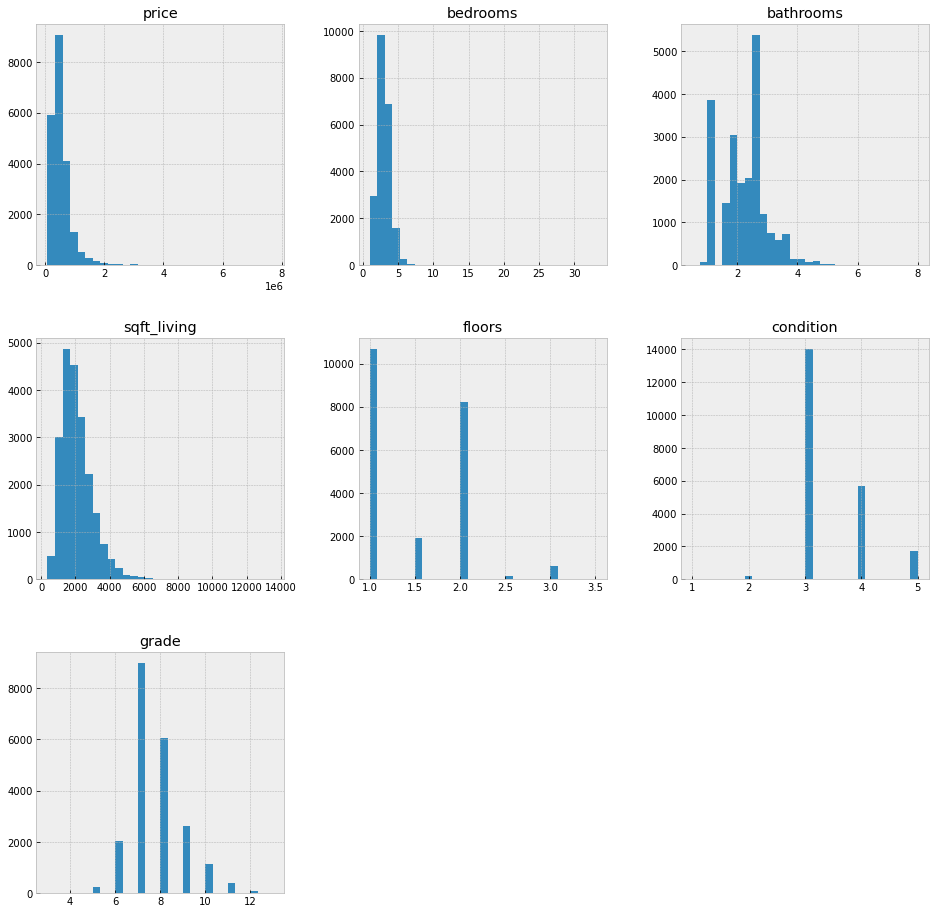

In [12]:
# Plots histograms for each variable
kc_df_iprep.hist(figsize=(16,16), bins=30);

There appears to be some outliers in the `bedrooms`, `sqft_living` and `price` columns. We will call outliers in `sqft_living` and `price` anything with values above 8,000 and 4,000,000 respectively. Let's take a look at bedroom values. 

In [13]:
# Checks bedrooms value counts
kc_df_iprep.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

There's one entry of 33 bedrooms that is much larger than the rest that will be ommitted.

In [14]:
# Checks the percentage of outliers contained in our dataset determined by defined values
len_of_outliers = len(kc_df_iprep[(kc_df_iprep.sqft_living > 8000)
                              | (kc_df_iprep.price > 4000000)
                              | (kc_df_iprep.bedrooms == 33)])
print('Percentage of outliers: {}%'.format(round(100*(len_of_outliers/len(kc_df_iprep)), 4)))

Percentage of outliers: 0.0695%


These outliers only account for about .07% of the data, thus will be omitted. While ommitting these entries duplicates will also be checked for and dropped.

In [15]:
# Drops outliers and duplicate entries
kc_df_iprep = dp.omit_outliers_dups(kc_df_iprep)

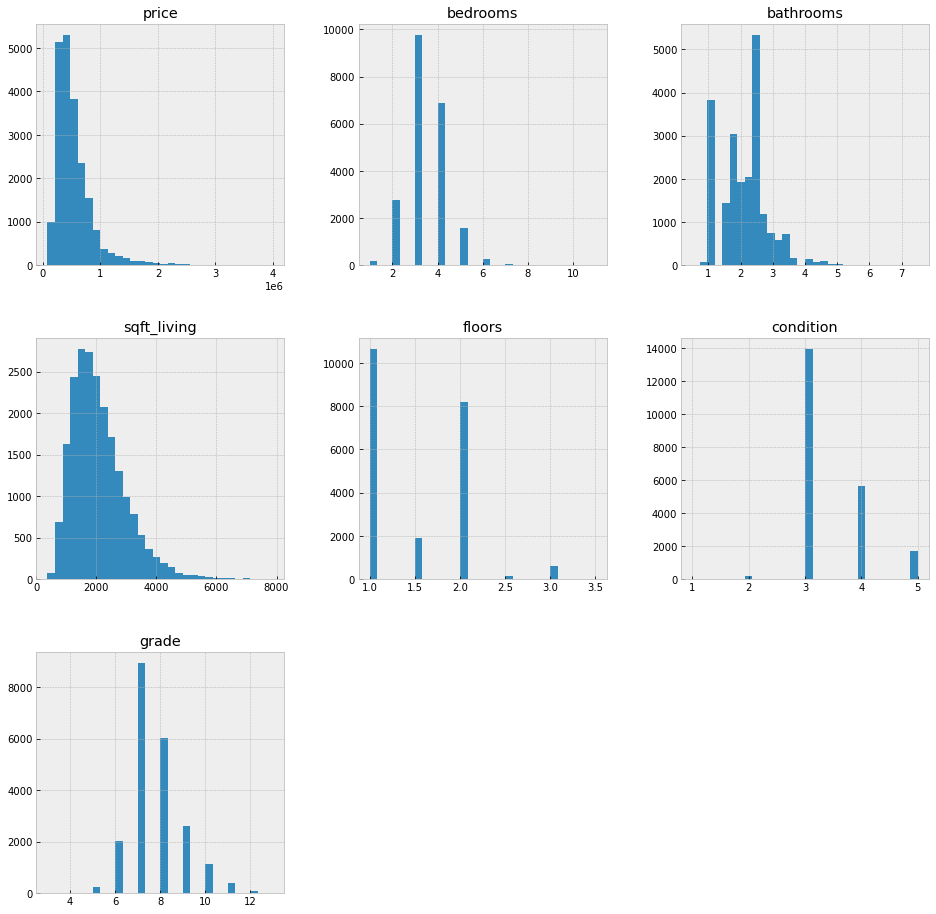

In [16]:
# Plots histograms for each variable
kc_df_iprep.hist(figsize=(16,16), bins=30);

Though the columns for `bedrooms`, `bathrooms`, `condition` and `grade` look like categories that can possible be One Hot Encoded, it will be difficult to make a suggestion based on the individual coefficients for each subcategory. Thus they will be treated as continuous features, they have already been encoded with appropriate numerical values.

With the initial prep done, let's split the dataset into a training and test set to later see if our models properly represent the data.

In [17]:
# Target Variable
y = kc_df_iprep.price.copy()

# independent variables
X = kc_df_iprep.drop(columns='price', axis=1).copy()

# Splits the data into two sets at a 4:1 ratio of variables for train:test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

## Modeling

The initial data preparation is completed, it's time to start our first model which will be a simple linear regression of the variable with the highest correlation to price.

### Base Model


In [18]:
# Checks correlation of all variables to price
pd.concat([X_train, y_train], axis=1).corr().price.sort_values(ascending=False)

price          1.000000
sqft_living    0.693351
grade          0.676487
bathrooms      0.520193
bedrooms       0.312859
floors         0.265260
condition      0.038695
Name: price, dtype: float64

The variable with the highest correlation to `price` is `sqft_living`. Let's take a look at the scatter plot and histograms for the variables.

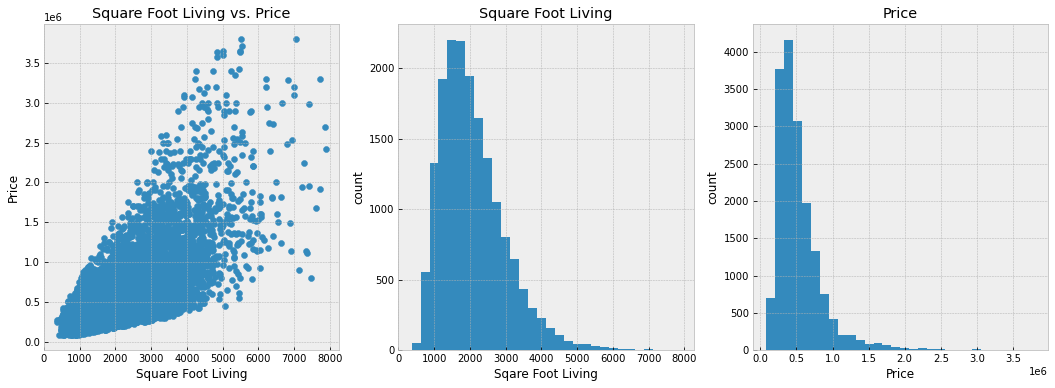

In [19]:
# Plots figures compairing price and sqft_living
fg.base_plots(X_train.sqft_living, y_train)

The histograms for square foot living and price show that the data is a bit skewed to the left. If our model performs poorly maybe we can check if the log of these variable will perform better. Our analysis cross validates all variables using a shuffle split that creates ten random samples of training and test sets from our training set. The scores reported below are the average R<sup>2</sup> values for both sets.

In [20]:
# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train[['sqft_living']], y_train, 'base_model')
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789


The resulting R<sup>2</sup> score has our modeling explaining only 48% of of our target variables variance. The Train and Test scores also very close. This shows that this model is underfit with a large bias and low variance. Let's take a quick look at the logs of these variables and the resulting model.

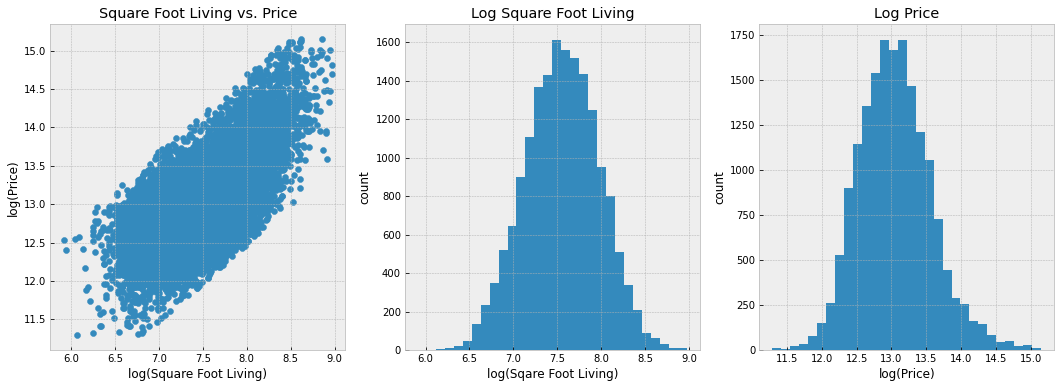

In [21]:
# Plots the log transformed figures
fg.base_plots_log(X_train.sqft_living, y_train)

It appears that the log of both variables is very similar to a normal distribution, and results in a more linear relationship between price and square foot living. Let's now test the linear regression model created from these variables.

In [22]:
# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(np.log(X_train[['sqft_living']]), np.log(y_train),
                   'log_base_model', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266


The R<sup>2</sup> scores have actually gone down compared to our original model even though there looks to be a more linear relationship, only explaining around 45% or our target variables variance. Therefore the previous model will be kept as our baseline model. 

### Model 2 - With all Features

Since the base model has a high bias and low variance, let's make it more complicated by adding all the features to the model and check the results.

In [23]:
# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train, y_train, 'model_2', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266
model_2,0.55422,0.55353


There is some clear improvement in the R<sup>2</sup> values of our second model. This model now explains around 55% of our target variables variance. While we did improve our bias by a decent amount, it is still pretty high. Our training and test scores are also still very close so our variance is low. This means we still have a pretty underfit model. Let's take a look at the scatter plots for all of the variables to check for linearity.

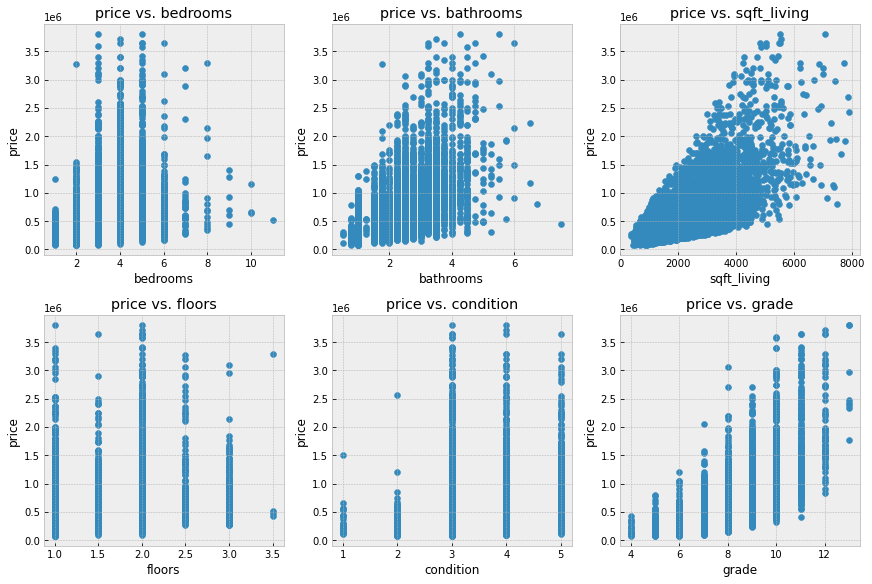

In [24]:
# plots seperate scatter plots of price vs all independent variables
fg.all_scatters(X_train, y_train)

There are a few features that don't have a very linear relationship with our target variable `price`, which breaks one assumption of linear regression. Let's take a look at the resulting coefficients and other scores resulting from this model.

In [25]:
# Creates model using statsmodels, and prints summary
model2 = dp.model_summary(X_train, y_train)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     3560.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:22:35   Log-Likelihood:            -2.3687e+05
No. Observations:               17184   AIC:                         4.738e+05
Df Residuals:                   17177   BIC:                         4.738e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.572e+05   1.99e+04    -38.114      0.000   -7.96e+05   -7.18e+05
bedrooms    -3.916e+04   2538.277    -15.430      0.000   -4.41e+04   -3.42e+04
bathrooms   -1.201e+04   3944.169     -3.046      0.002   -1.97e+04   -4283.756
sqft_living   195.0414      3.945     49.440      0.000     187.309     202.774
floors        -1.6e+04   4066.052     -3.934      0.000    -2.4e+04   -8027.870
condition    6.353e+04   2877.749     22.076      0.000    5.79e+04    6.92e+04
grade        1.116e+05   2558.692     43.627      0.000    1.07e+05    1.17e+05
==============================================================================
Omnibus:                     9645.392   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           153046.021
Skew:                           2.366   Prob(JB):                         0.00
Kurtosis:                      16.833   Cond. No.                     2.55e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the summary the three features with the most impact on price are `grade`, `condition` and `sqft_living`. Something that also stands out is the Jarque-Bera score which in a residual normality check. One of assumptions of linear regression is that the residuals are normally distributed. The extremely high score of 153,046 shows that this isn't true for this model.

### Model 3 - Check for Multicollinearity

Looking at the columns there may be some the are collinear, let's check the dataset for multicollinearity and adjust the model as needed.

In [26]:
# Prints top pairs with highest correlation
feature_corr = dp.correlation_check(X_train)
feature_corr

,cc
pairs,
"(grade, sqft_living)",0.765227
"(bathrooms, sqft_living)",0.754150
"(bathrooms, grade)",0.663297
"(sqft_living, bedrooms)",0.590357
"(bathrooms, bedrooms)",0.527167
"(bathrooms, floors)",0.504449
"(floors, grade)",0.460983
"(floors, sqft_living)",0.359470
"(bedrooms, grade)",0.356576


It appears the column `sqft_living` has high correlation with a lot of features. This makes sense since bedrooms and bathrooms are a part of the living space in a house. One can also argue that during renovations the most common additions are bedrooms and bathrooms. Therefore this next model will remove the `sqft_living` feature.

In [27]:
# Creates training set for model 3
X_train_model3 = X_train.drop(columns='sqft_living', axis=1)

# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train_model3, y_train, 'model_3', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266
model_2,0.55422,0.55353
model_3,0.49061,0.49099


In [28]:
# Creates model using statsmodels, and prints summary
model3 = dp.model_summary(X_train_model3, y_train)
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     3312.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:22:35   Log-Likelihood:            -2.3801e+05
No. Observations:               17184   AIC:                         4.760e+05
Df Residuals:                   17178   BIC:                         4.761e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.234e+06   1.86e+04    -66.515      0.000   -1.27e+06    -1.2e+06
bedrooms    9564.8797   2499.921      3.826      0.000    4664.779    1.45e+04
bathrooms    6.62e+04   3861.355     17.145      0.000    5.86e+04    7.38e+04
floors     -4.143e+04   4310.704     -9.610      0.000   -4.99e+04    -3.3e+04
condition   7.114e+04   3071.198     23.164      0.000    6.51e+04    7.72e+04
grade       1.855e+05   2220.567     83.518      0.000    1.81e+05     1.9e+05
==============================================================================
Omnibus:                    10417.529   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178464.072
Skew:                           2.606   Prob(JB):                         0.00
Kurtosis:                      17.902   Cond. No.                         93.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model has worse R<sup>2</sup> scores than the previous model, explaining only 49% of our target variables variance. The Jarque-Bera score is still extremely high as well at around 178,000.

### Model 4 - Multiple Correlation Fix

Removing the feature `sqft_living` because of multicollinearity didn't improve our model, this may be because it also has the most linear relationship with our target variable. For this model let's try removing some features that have high collinearity with `sqft_living` instead. These features will include `bedrooms` and `bathrooms`. 

In [29]:
# Creates independent training data used for model 4
X_train_model4 = X_train.drop(columns=['bedrooms', 'bathrooms'], axis=1)

# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train_model4, y_train, 'model_4', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266
model_2,0.55422,0.55353
model_3,0.49061,0.49099
model_4,0.54715,0.54587


In [30]:
# Creates model using statsmodels, and prints summary
model4 = dp.model_summary(X_train_model4, y_train)
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     5188.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:22:35   Log-Likelihood:            -2.3701e+05
No. Observations:               17184   AIC:                         4.740e+05
Df Residuals:                   17179   BIC:                         4.741e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -8.72e+05   1.86e+04    -46.787      0.000   -9.09e+05   -8.35e+05
sqft_living   159.1516      3.102     51.311      0.000     153.072     165.231
floors      -2.239e+04   3867.338     -5.790      0.000      -3e+04   -1.48e+04
condition    6.142e+04   2895.655     21.211      0.000    5.57e+04    6.71e+04
grade         1.18e+05   2515.535     46.906      0.000    1.13e+05    1.23e+05
==============================================================================
Omnibus:                     9817.459   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           159057.008
Skew:                           2.417   Prob(JB):                         0.00
Kurtosis:                      17.099   Cond. No.                     2.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model performed slightly worse than model two with a comparable Jarque-Bera score and an R<sup>2</sup> score of .547 compared to .554. Though one could argue that this may be the prefered model considerer it is "simpler" than model two by having less features.

### Model 5

Since the fourth model has arguably been the best model to use so far, it's residuals will be examined to determine if there are outliers causing the lack of normality.

Let's check the residual distribution.

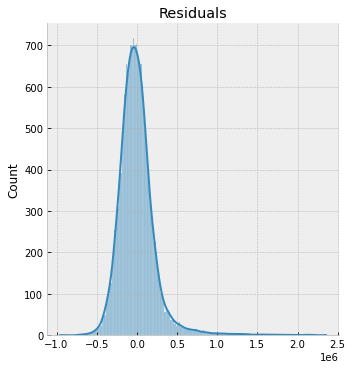

In [31]:
sns.displot(model4.resid, kde=True);
plt.title('Residuals');

The residual plot clearly shows a long tail on the right side. Let's check if any features are associated with the residuals above 100,000 since the left tail ends at around -100,000 and the center is pretty close to 0.

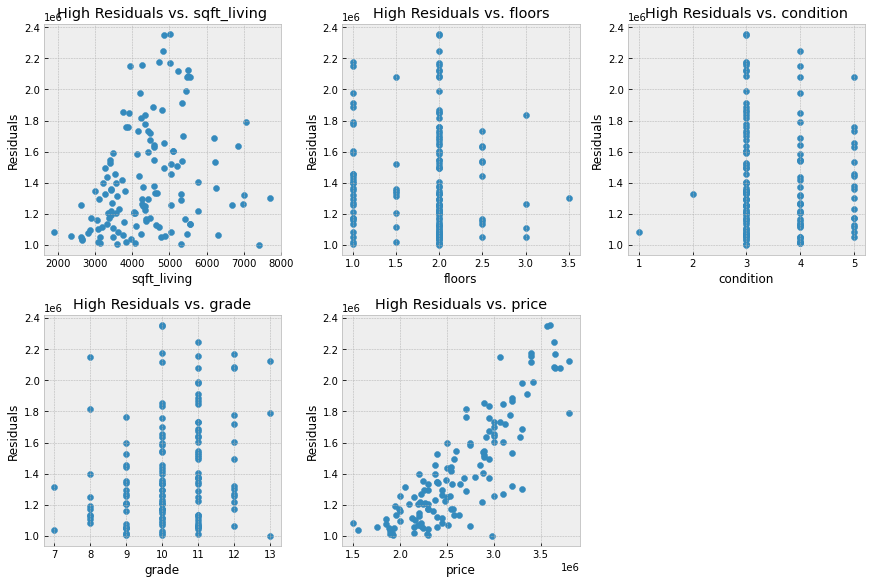

In [32]:
fg.high_resid_plots(X_train_model4, y_train, model4, 1e6)

It appears that the entries with high residuals are spread out for the features `floors` and `condition`. For the other features they may only cover a portion of the feature. Let's check what percentage of the dataset is above the lowest value for the features `sqft_living`, `grade` and `price`.

In [33]:
columns = ['sqft_living', 'grade', 'price']
dp.outlier_percentage(X_train_model4, y_train, model4, 1e6, columns)

sqft_living: 50.57%
grade: 89.28%
price: 2.47%


The percentage of entries above the lowest value of the high residual entries for `price` is only around %2.5. The percentage for features `sqft_living` and `grade` are extremely high, so for this model let's try taking out the entries depending on `price`.

In [34]:
model5_sets = dp.model5_data(X_train_model4, y_train, X_test, y_test, model4, 1e6, 'price')
print('Price Cutoff = ${}'.format(model5_sets['cutoff']))

Price Cutoff = $1500000.0


With a cutoff price being set, this model can only be used for houses with a sales price lower than 1.5 million dollars. 

Using this new training set, we can now build our model.

In [35]:
# Grabs training set data
X_train_model5 = model5_sets['X_train']
y_train_cutoff = model5_sets['y_train']

# Cross validates training data from fifth model
model5_results = dp.cross_val(X_train_model5, y_train_cutoff)

# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train_model5, y_train_cutoff, 'model_5', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266
model_2,0.55422,0.55353
model_3,0.49061,0.49099
model_4,0.54715,0.54587
model_5,0.52186,0.51598


In [36]:
model5 = dp.model_summary(X_train_model5, y_train_cutoff)
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     4551.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:22:38   Log-Likelihood:            -2.2574e+05
No. Observations:               16760   AIC:                         4.515e+05
Df Residuals:                   16755   BIC:                         4.515e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.129e+05   1.39e+04    -44.055      0.000    -6.4e+05   -5.86e+05
sqft_living   104.7087      2.358     44.404      0.000     100.087     109.331
floors      -2245.8545   2842.243     -0.790      0.429   -7816.950    3325.241
condition    4.887e+04   2134.928     22.890      0.000    4.47e+04    5.31e+04
grade         9.73e+04   1869.912     52.035      0.000    9.36e+04    1.01e+05
==============================================================================
Omnibus:                     2330.963   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4488.900
Skew:                           0.880   Prob(JB):                         0.00
Kurtosis:                       4.826   Cond. No.                     2.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The resulting model has a lower R<sup>2</sup> score of around .521 compared to .547 of the fourth model. The Jarcque-Bera score is still pretty high, though compared to model 4 it has greatly improved. One thing to note though is the large condition number that may be caused by the large P value for feature `floors`. Let's try a model without the floors column.

### Model 6

In [37]:
# Creates independent training data used for model 6
X_train_model6 = X_train_model5.drop(columns='floors', axis=1)

# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train_model6, y_train_cutoff, 'model_6', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266
model_2,0.55422,0.55353
model_3,0.49061,0.49099
model_4,0.54715,0.54587
model_5,0.52186,0.51598
model_6,0.52183,0.51604


In [38]:
model6 = dp.model_summary(X_train_model6, y_train_cutoff)
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     6068.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:22:38   Log-Likelihood:            -2.2574e+05
No. Observations:               16760   AIC:                         4.515e+05
Df Residuals:                   16756   BIC:                         4.515e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.141e+05   1.38e+04    -44.427      0.000   -6.41e+05   -5.87e+05
sqft_living   104.6336      2.356     44.408      0.000     100.015     109.252
condition    4.925e+04   2079.421     23.685      0.000    4.52e+04    5.33e+04
grade        9.687e+04   1789.949     54.120      0.000    9.34e+04       1e+05
==============================================================================
Omnibus:                     2333.887   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4494.887
Skew:                           0.881   Prob(JB):                         0.00
Kurtosis:                       4.826   Cond. No.                     2.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing the `floor` feature didn't improve the condition number, this brings to light that it may be a scaling issue since `sqft_living` has a much higher value than those of the other features. Let's try scaling the `sqft_living` feature down by 1000.

### Model 7

In [39]:
# Creates independent training data used for model 7
X_train_model7 = X_train_model6.copy()
X_train_model7.sqft_living = X_train_model7.sqft_living/1000

# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train_model7, y_train_cutoff, 'model_7', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266
model_2,0.55422,0.55353
model_3,0.49061,0.49099
model_4,0.54715,0.54587
model_5,0.52186,0.51598
model_6,0.52183,0.51604
model_7,0.52183,0.51604


In [40]:
model7 = dp.model_summary(X_train_model7, y_train_cutoff)
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     6068.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:22:38   Log-Likelihood:            -2.2574e+05
No. Observations:               16760   AIC:                         4.515e+05
Df Residuals:                   16756   BIC:                         4.515e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.141e+05   1.38e+04    -44.427      0.000   -6.41e+05   -5.87e+05
sqft_living  1.046e+05   2356.165     44.408      0.000       1e+05    1.09e+05
condition    4.925e+04   2079.421     23.685      0.000    4.52e+04    5.33e+04
grade        9.687e+04   1789.949     54.120      0.000    9.34e+04       1e+05
==============================================================================
Omnibus:                     2333.887   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4494.887
Skew:                           0.881   Prob(JB):                         0.00
Kurtosis:                       4.826   Cond. No.                         92.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Scaling the feature `sqft_living` has solved the high condition number issue. Let's try to validate this as the final model with it's R<sup>2</sup> score of around .521, relatively low Jarque-Bera score, simplicity and low condition number.  

### Model 7 Validation

Linear regression models need to fulfill four assumptions.
<ol>
    <li>Linearity</li>
    <li>Residual Normality</li>
    <li>Homoskedasticity</li>
    <li>Features are Linearly Independant</li>
</ol>

#### Linearity

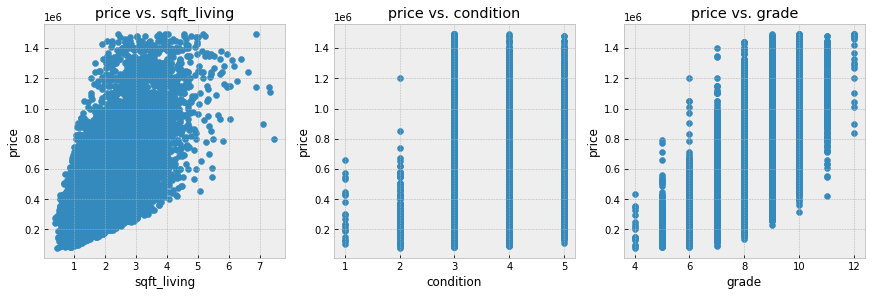

In [41]:
# plots seperate scatter plots of price vs all features
fg.all_scatters(X_train_model7, y_train_cutoff)

The data for `sqft_living` and `grade` cones out but sees to be following a linear direction. The `condition` plot doesn't appear linear at all. Let's check a quick density plot to get a better idea of its trend.

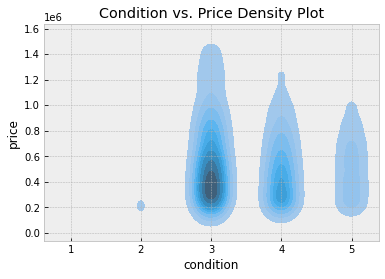

In [42]:
sns.kdeplot(x=X_train_model7.condition, y=y_train_cutoff, fill=True);
plt.title('Condition vs. Price Density Plot');

While the price range at each condition level fans pretty wide, it appears the the densest regions of each are in a linear trend.

#### Normality

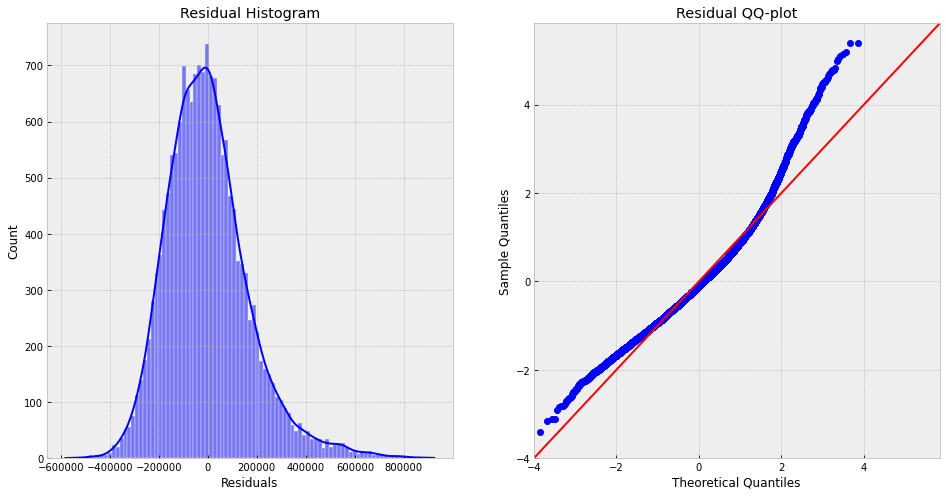

In [43]:
fg.normality_plots(model7.resid)

In [44]:
jb = jarque_bera(model7.resid)
print('Jarque Bera Score: {}'.format(round(jb[0], 2)))
print('Jarque Bera P-value: {}'.format(round(jb[1], 4)))

Jarque Bera Score: 4494.89
Jarque Bera P-value: 0.0


The plots show a distribution that is skewed to the left, with a short left tail, and a thicker longer right tail. The QQ-plot confirms that the distribution is skewed. The Jarque Bera score is still pretty high, though it is relatively low compared to the other models attempted in this notebook. As shown before, to improve this the log function of the target variable and some features must be taken. While this helped with making the residuals have a more normal distribution it made the model very complicated to understand and use.

#### Homoskedasticity

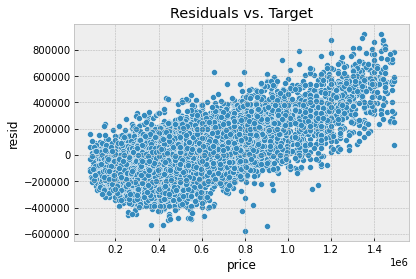

In [45]:
fg.homoskedasticity_plot(y_train_cutoff, model7)

The plot above shows a scatter plot of the residuals against the expected outcome. In order for the model to be homoscedastic the residual variance needs to be continuous throughout the whole range of outcomes. This plot clearly shows that this model is not homoskedastic by curving upward as the expected value increase.

This model has failed the assumptions of homoskedasticity and residual normality, while also arguably failing linearity. Thus more modeling has to be completed. 

### Model 8 - Log Features

As seen before `sqft_living` and `price` appear to have a logarithmic form. Let's try a model by taking the log of these variables. Model 4 will be used as the base model before being log transformed. Model 4 included data with a price greater than 1.5 million dollars.

In [46]:
# Creates independent training data used for model 8
X_train_model8 = dp.log_columns(X_train_model4, columns='sqft_living')
y_train_log = dp.log_columns(y_train)

# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train_model8, y_train_log, 'model_8', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266
model_2,0.55422,0.55353
model_3,0.49061,0.49099
model_4,0.54715,0.54587
model_5,0.52186,0.51598
model_6,0.52183,0.51604
model_7,0.52183,0.51604
model_8,0.55860,0.55869


In [47]:
# Creates model using statsmodels, and prints summary
model8 = dp.model_summary(X_train_model8, y_train_log)
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     5437.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:22:48   Log-Likelihood:                -6247.8
No. Observations:               17184   AIC:                         1.251e+04
Df Residuals:                   17179   BIC:                         1.254e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.0534      0.056    144.352      0.000       7.944       8.163
log_sqft_living     0.3989      0.009     42.352      0.000       0.380       0.417
floors              0.0056      0.006      0.975      0.329      -0.006       0.017
condition           0.1007      0.004     23.589      0.000       0.092       0.109
grade               0.2131      0.004     60.030      0.000       0.206       0.220
==============================================================================
Omnibus:                       64.953   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.607
Skew:                           0.151   Prob(JB):                     5.67e-15
Kurtosis:                       3.017   Cond. No.                         244.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Taking the log of out target variable `sales_price` and feature `sqft_living` slightly improves the models R<sup>2</sup> score while significantly improving the Jarque-Bera score to 65.6. One thing to point out again is the high P-value of the feature `floors`. Let's try a new model without this feature.

### Model 9

In [48]:
# Creates independent training data used for model 9
X_train_model9 = X_train_model8.drop(columns='floors', axis=1)

# Returns dataframe consisting models cross validated average Rsquared scores
df_rsquared_cv = dp.rsquared_df(X_train_model9, y_train_log, 'model_9', df_rsquared_cv)
df_rsquared_cv

,train_rsquared,test_rsquared
base_model,0.48122,0.47789
log_base_model,0.45292,0.45266
model_2,0.55422,0.55353
model_3,0.49061,0.49099
model_4,0.54715,0.54587
model_5,0.52186,0.51598
model_6,0.52183,0.51604
model_7,0.52183,0.51604
model_8,0.55860,0.55869
model_9,0.55856,0.55876


In [49]:
# Creates model using statsmodels, and prints summary
model9 = dp.model_summary(X_train_model9, y_train_log)
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     7250.
Date:                Thu, 12 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:22:48   Log-Likelihood:                -6248.3
No. Observations:               17184   AIC:                         1.250e+04
Df Residuals:                   17180   BIC:                         1.254e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.0530      0.056    144.349      0.000       7.944       8.162
log_sqft_living     0.3995      0.009     42.529      0.000       0.381       0.418
condition           0.0997      0.004     24.004      0.000       0.092       0.108
grade               0.2140      0.003     62.567      0.000       0.207       0.221
==============================================================================
Omnibus:                       62.965   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.578
Skew:                           0.149   Prob(JB):                     1.56e-14
Kurtosis:                       3.016   Cond. No.                         242.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's try and validate this model, since it has a relatively good R<sup>2</sup> score of .559, a good Jarque-Bera of 63.6, and condition numbers of 242.

### Model 9 Validation

#### Linearity

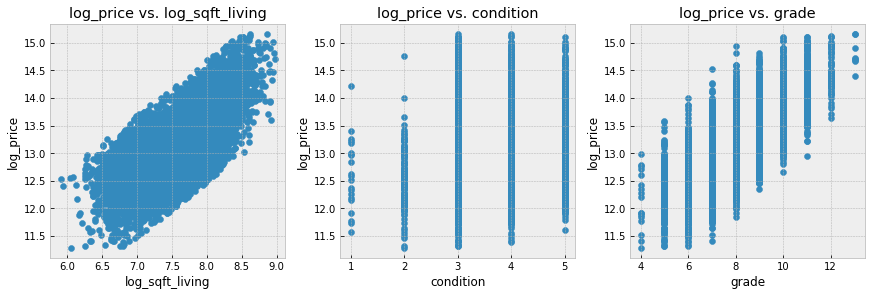

In [50]:
# plots seperate scatter plots of price vs all features
fg.all_scatters(X_train_model9, y_train_log)

The figures containing features `log_sqft_living` and `grade` are clearly much more linear than the previous attempt at validating model 7. Though the figure for `condition` is on the border. Once again lets check the density plot.

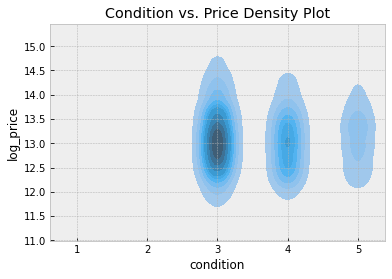

In [51]:
sns.kdeplot(x=X_train_model9.condition, y=y_train_log, fill=True);
plt.title('Condition vs. Price Density Plot');

The densest parts are more centered and appear to be more linearly alligned than with model 7. After looking at these figure I can comfortably say our variables are linear.

#### Normality

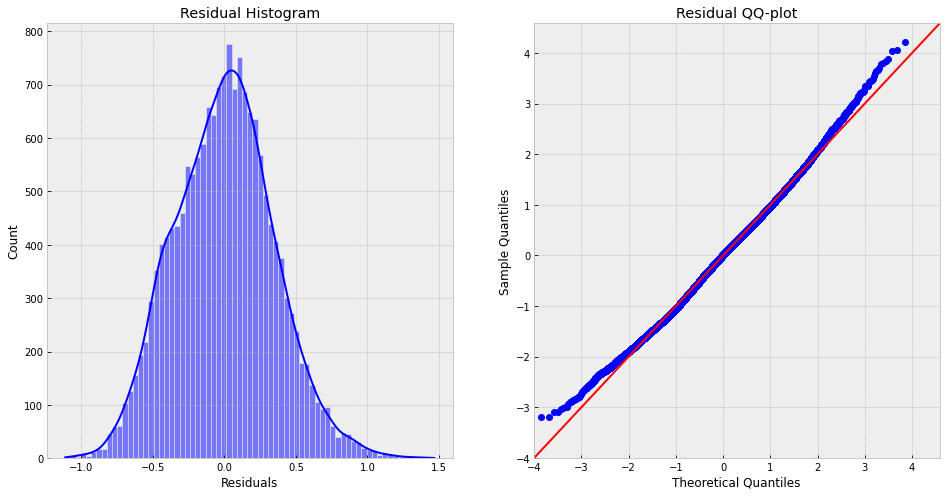

In [52]:
fg.normality_plots(model9.resid)

Though the models residual distribution isn't perfectly normal with it's short tails. It appears to be more center and is certainly an improvement to model 7.

#### Homoskedasticity

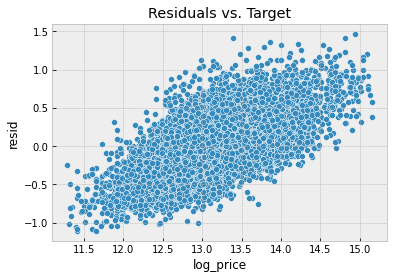

In [54]:
fg.homoskedasticity_plot(y_train_log, model9)

While the residuals don't appear to be 

To check if our model can be used on untrained data let's check the mean squared error for the training and test sets.